# COVID19 DRUG DISCOVERY

The data for this project was taken from kaggle: https://www.kaggle.com/divyansh22/drug-discovery-data

The goal of this project is to determine if any of these compounds are active against COVID19 based upon experimental data and engineered features using pubchempy. Additionally, we will use machine learning methods to predict the pIC50 values of blinded compounds based upon the aforementioned features.

## COVID19 Drug Discovery efforts and understanding

COVID19 has had substantial impacts on the world, affecting the livelihoods of families, economies of all nations, with almost 6 million deaths worldwide since it's appearance in 2020. While vaccines have been effective in reducing disease severity upon infection, the safety of these vaccines and the policies surrounding their administration continue to be a source of fierce debate. As with any pandemic, efforts towards finding small molecule therapeutics remained at the forefront of combating this disease. This dataset contains experimental and engineered data features for over 100 compounds. 

Many features in the dataset are crucial for determining how well these compounds act against COVID19. pIC50 and XlogP are the typical hallmark pharmacological variables that indicate how effective a compound will be as a potential therapeutic. pIC50 is the logrithimic transformation of IC50, which determines the concentration necessary to inhibit 50% of the activity of the drug target or the targeted biological process. LogP is a measure of lipophlicity which is used to determine how well the drug will be absorbed by the body. IC50s in the nanomolar (nM) or picomolar (pM) ranges are usually considered to be very active compounds, while certain LogP values are optimal dependent upon how the drug will be administered. Oral, subcutaneous, rectal, and injectible routes of drug administration all have optimal LogP values that determine the best route of administration. 

The engineered dataset values such as HBondDonorCount, FeatureCounts, etc all hold key information about the drug structure itself that could potentially influence it's activity. The presence of Hydrogen bond donors and acceptors, as well as features releated to stereochemistry (StereoCounts) can affect how well the target binds to the drug.

Finally, certain features don't impact drug activity at all (Molecular formula, Weight, SMILES, CID, etc). While these are important features for describing general characteristics of the compound, they are not effective predictors of drug efficacy and will likely not be a part of the predictive model. 

In [1]:
#!pip install pubchempy

In [2]:
#import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
import pubchempy as pcp

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
import scipy.stats as stats

In [3]:
df = pd.read_csv('DDH Data with Properties.csv', sep=",", header=0)
df.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.998609,471.998609,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.035865,509.035865,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,NNVVKOVHRSDRSQ-UHFFFAOYSA-N,N-(2-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.004901,459.004901,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CID                       104 non-null    int64  
 1   SMILES                    104 non-null    object 
 2   MolecularFormula          104 non-null    object 
 3   MolecularWeight           104 non-null    float64
 4   InChI                     104 non-null    object 
 5   InChIKey                  101 non-null    object 
 6   IUPACName                 101 non-null    object 
 7   XLogP                     101 non-null    float64
 8   ExactMass                 101 non-null    float64
 9   MonoisotopicMass          101 non-null    float64
 10  TPSA                      101 non-null    float64
 11  Complexity                101 non-null    float64
 12  Charge                    101 non-null    float64
 13  HBondDonorCount           101 non-null    float64
 14  HBondAccep

In [5]:
df.shape

(104, 40)

In [6]:
df.isna().sum()

CID                         0
SMILES                      0
MolecularFormula            0
MolecularWeight             0
InChI                       0
InChIKey                    3
IUPACName                   3
XLogP                       3
ExactMass                   3
MonoisotopicMass            3
TPSA                        3
Complexity                  3
Charge                      3
HBondDonorCount             3
HBondAcceptorCount          3
RotatableBondCount          3
HeavyAtomCount              3
IsotopeAtomCount            3
AtomStereoCount             3
DefinedAtomStereoCount      3
UndefinedAtomStereoCount    3
BondStereoCount             3
DefinedBondStereoCount      3
UndefinedBondStereoCount    3
CovalentUnitCount           3
Volume3D                    3
XStericQuadrupole3D         4
YStericQuadrupole3D         4
ZStericQuadrupole3D         4
FeatureCount3D              4
FeatureAcceptorCount3D      4
FeatureDonorCount3D         4
FeatureAnionCount3D         4
FeatureCat

### Insight:
SMILES, molecular formula, InChI, key, and IUPAC name are not important indicators for compound efficacy. will drop from df.

In [7]:
df2 = df.drop(['SMILES', 'MolecularFormula', 'InChI', 'InChIKey', 'IUPACName'], axis=1)
df2.head()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
3,2820914,519.1,6.3,518.013024,518.013024,175.0,635.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
4,2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036


In [8]:
df2.columns

Index(['CID', 'MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass',
       'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D', 'pIC50'],
      dtype='object')

In [9]:
#create df with blinded values

blinded_df = df2[df2['pIC50'] == 'BLINDED']

blinded_df        

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
3,2820914,519.10,6.3,518.013024,518.013024,175.0,635.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.2,8.0,10.0,BLINDED
22,135427623,437.40,2.5,437.079390,437.079390,175.0,835.0,0.0,2.0,8.0,...,6.0,2.0,1.0,0.0,3.0,0.0,1.0,8.0,10.0,BLINDED
27,164676,294.30,4.3,294.125594,294.125594,47.3,509.0,0.0,0.0,3.0,...,3.0,0.0,0.0,0.0,4.0,1.0,0.6,0.8,1.0,BLINDED
41,2799801,494.50,4.4,494.126006,494.126006,167.0,935.0,0.0,2.0,10.0,...,6.0,2.0,0.0,2.0,2.0,0.0,1.2,12.0,10.0,BLINDED
45,2799800,588.60,5.4,588.177766,588.177766,172.0,946.0,0.0,2.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLINDED
57,16204323,379.10,4.4,377.981027,377.981027,98.2,503.0,0.0,0.0,6.0,...,5.0,0.0,1.0,0.0,3.0,0.0,1.0,5.0,10.0,BLINDED
62,16202740,268.09,3.5,266.985384,266.985384,39.2,267.0,0.0,0.0,3.0,...,2.0,0.0,0.0,0.0,2.0,0.0,0.6,3.0,10.0,BLINDED
67,58589722,309.34,-0.4,309.078327,309.078327,95.2,548.0,0.0,1.0,6.0,...,4.0,1.0,0.0,1.0,3.0,0.0,0.6,3.4,10.0,BLINDED
73,4117383,294.33,0.6,294.067428,294.067428,91.9,519.0,0.0,1.0,5.0,...,4.0,1.0,0.0,0.0,3.0,0.0,0.6,3.4,10.0,BLINDED
94,44398167,421.18,3.0,420.981100,420.981100,55.8,499.0,0.0,0.0,4.0,...,4.0,0.0,0.0,0.0,4.0,1.0,0.6,3.0,10.0,BLINDED


In [10]:
blinded_df.shape

(10, 35)

In [11]:
#removing blinded pIC50 values from main dataframe

df2 = df2.loc[df2['pIC50'] != 'BLINDED']
df2.shape

(94, 35)

In [12]:
#removing rows where CID=0

df2 = df2.loc[df2['CID'] != 0]
df2.head()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
4,2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
5,2745617,422.9,4.4,422.060425,422.060425,106.0,529.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [13]:
df2.shape

(91, 35)

In [14]:
df2.isnull().values.any()

False

In [15]:
#setting CID as index so values do not interfere with analysis

df2.set_index(df2['CID'], inplace=True)
df2.head()

,CID,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
2821293,2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2820912,2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
2744846,2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
2745617,2745617,422.9,4.4,422.060425,422.060425,106.0,529.0,0.0,1.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [16]:
#dropping CID as a feature

df2.drop('CID', axis=1, inplace=True)
df2.head()

,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,473.4,5.6,471.998609,471.998609,121.0,559.0,0.0,1.0,6.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
2821293,510.0,4.9,509.035865,509.035865,126.0,670.0,0.0,1.0,9.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2820912,519.1,6.3,518.013024,518.013024,175.0,627.0,0.0,1.0,8.0,7.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
2744846,460.0,4.4,459.004901,459.004901,162.0,554.0,0.0,1.0,8.0,6.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
2745617,422.9,4.4,422.060425,422.060425,106.0,529.0,0.0,1.0,6.0,6.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [17]:
df2.columns

Index(['MolecularWeight', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'TPSA',
       'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'IsotopeAtomCount',
       'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D', 'pIC50'],
      dtype='object')

In [18]:
for x in df2.columns:
    print(df2.value_counts(x))

MolecularWeight
344.70    3
322.40    2
234.64    2
278.65    2
399.50    2
         ..
338.30    1
334.40    1
334.10    1
331.30    1
565.00    1
Length: 83, dtype: int64
XLogP
 4.1    7
 3.3    5
 3.8    5
 2.7    4
 4.9    4
 4.7    4
 3.7    4
 2.8    3
 1.1    3
 1.2    3
 1.4    3
 4.6    3
 1.8    3
 3.6    2
 3.4    2
-0.6    2
 3.9    2
 5.9    2
 4.4    2
 3.2    2
 1.6    2
 2.3    2
 1.5    2
 3.1    1
 6.3    1
 0.2    1
 5.6    1
 5.5    1
 5.0    1
 0.7    1
 1.0    1
 4.5    1
 4.2    1
-0.5    1
 1.7    1
 4.0    1
 2.2    1
 2.4    1
 2.5    1
 3.5    1
 2.6    1
 2.9    1
 7.3    1
dtype: int64
ExactMass
344.019999    3
322.098728    2
278.009434    2
234.019605    2
399.125277    2
             ..
338.036128    1
334.055818    1
332.995948    1
331.062677    1
563.814325    1
Length: 83, dtype: int64
MonoisotopicMass
344.019999    3
322.098728    2
278.009434    2
234.019605    2
399.125277    2
             ..
338.036128    1
334.055818    1
332.995948    1
331.06

### Insight
Some of these features don't have any effect on drug action (Mass, molecular weight) and others only have one value for every molecule listed (Charge, isotopeatomcount, etc). These features will be dropped from the dataset, as they don't have a substantial effect on drug efficacy.

In [19]:
#drop columns with only one value and columns that don't contribute to drug action.

todrop = ['MolecularWeight', 'ExactMass', 'MonoisotopicMass', 'Charge', 'IsotopeAtomCount', 'DefinedAtomStereoCount', 
          'UndefinedBondStereoCount', 'CovalentUnitCount']

df2.drop(todrop, axis=1, inplace=True)
df2.shape

(91, 26)

In [20]:
df2.head(10)

,XLogP,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,AtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
CID,,,,,,,,,,,,,,,,,,,,,
2744814,5.6,121.0,559.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
2821293,4.9,126.0,670.0,1.0,9.0,6.0,33.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2820912,6.3,175.0,627.0,1.0,8.0,7.0,32.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
2744846,4.4,162.0,554.0,1.0,8.0,6.0,29.0,0.0,0.0,0.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
2745617,4.4,106.0,529.0,1.0,6.0,6.0,29.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259
2745640,5.9,106.0,687.0,1.0,9.0,6.0,34.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,8.0,10.0,-1.176091259
2745653,5.0,106.0,567.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259
16075059,4.7,80.2,354.0,1.0,4.0,6.0,22.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,2.0,1.0,0.8,7.0,10.0,-1.477121255
135411083,1.2,197.0,955.0,3.0,9.0,7.0,32.0,0.0,0.0,0.0,...,6.0,3.0,0.0,0.0,3.0,0.0,1.2,8.0,10.0,-1.602059991


## EDA of Features

Now that we have a clean dataset, we will explore the data and look for collinearity and other trends.

In [21]:
df2.columns

Index(['XLogP', 'TPSA', 'Complexity', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'AtomStereoCount',
       'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount',
       'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D',
       'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D',
       'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D',
       'FeatureRingCount3D', 'FeatureHydrophobeCount3D',
       'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'ConformerCount3D',
       'pIC50'],
      dtype='object')

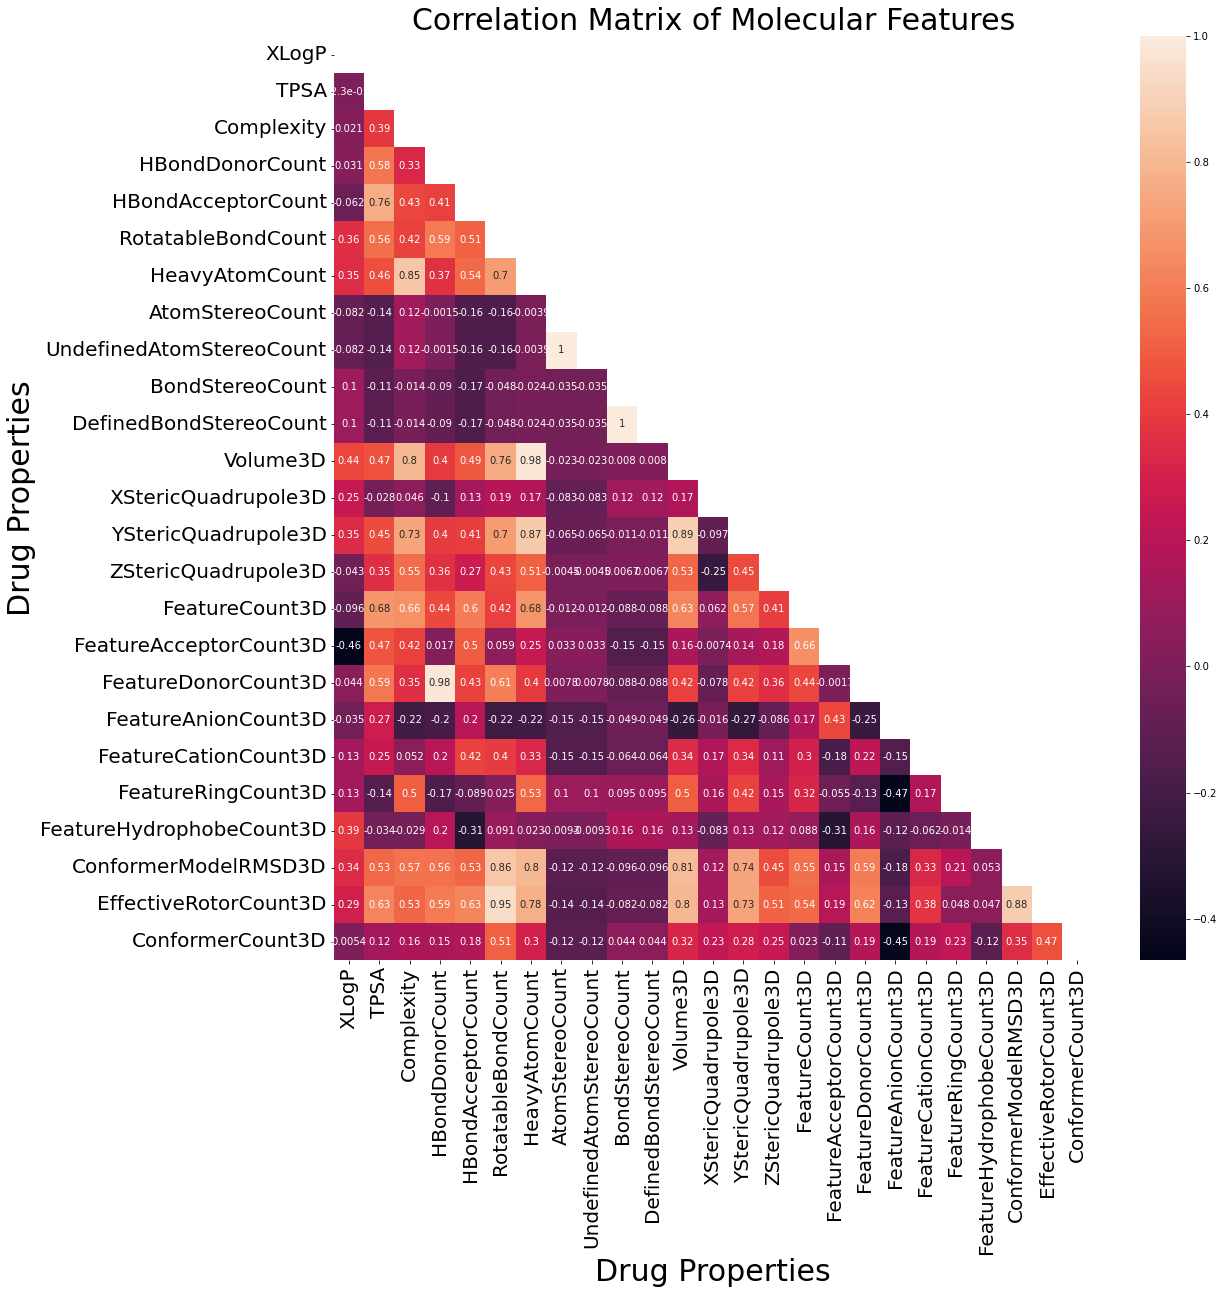

In [22]:
#plot correlation matrix to detect multicollinearity of features

corrmatrix = df2.corr()
matrix = np.triu(corrmatrix)

# plot correlation matrix in heat map with seaborn
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrmatrix, annot=True, mask=matrix)

# label plot
plt.title('Correlation Matrix of Molecular Features', size=30)
plt.xlabel('Drug Properties', size=30)
plt.ylabel('Drug Properties', size=30)
plt.xticks(size=20)
plt.yticks(size=20);

### Insight
Some of these features are highly correlated (r > 0.7), which can cause problems for potential regression analysis

In [23]:
#function to draw histograms of the features to determine their distribution

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(30, 25))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  
    plt.show()




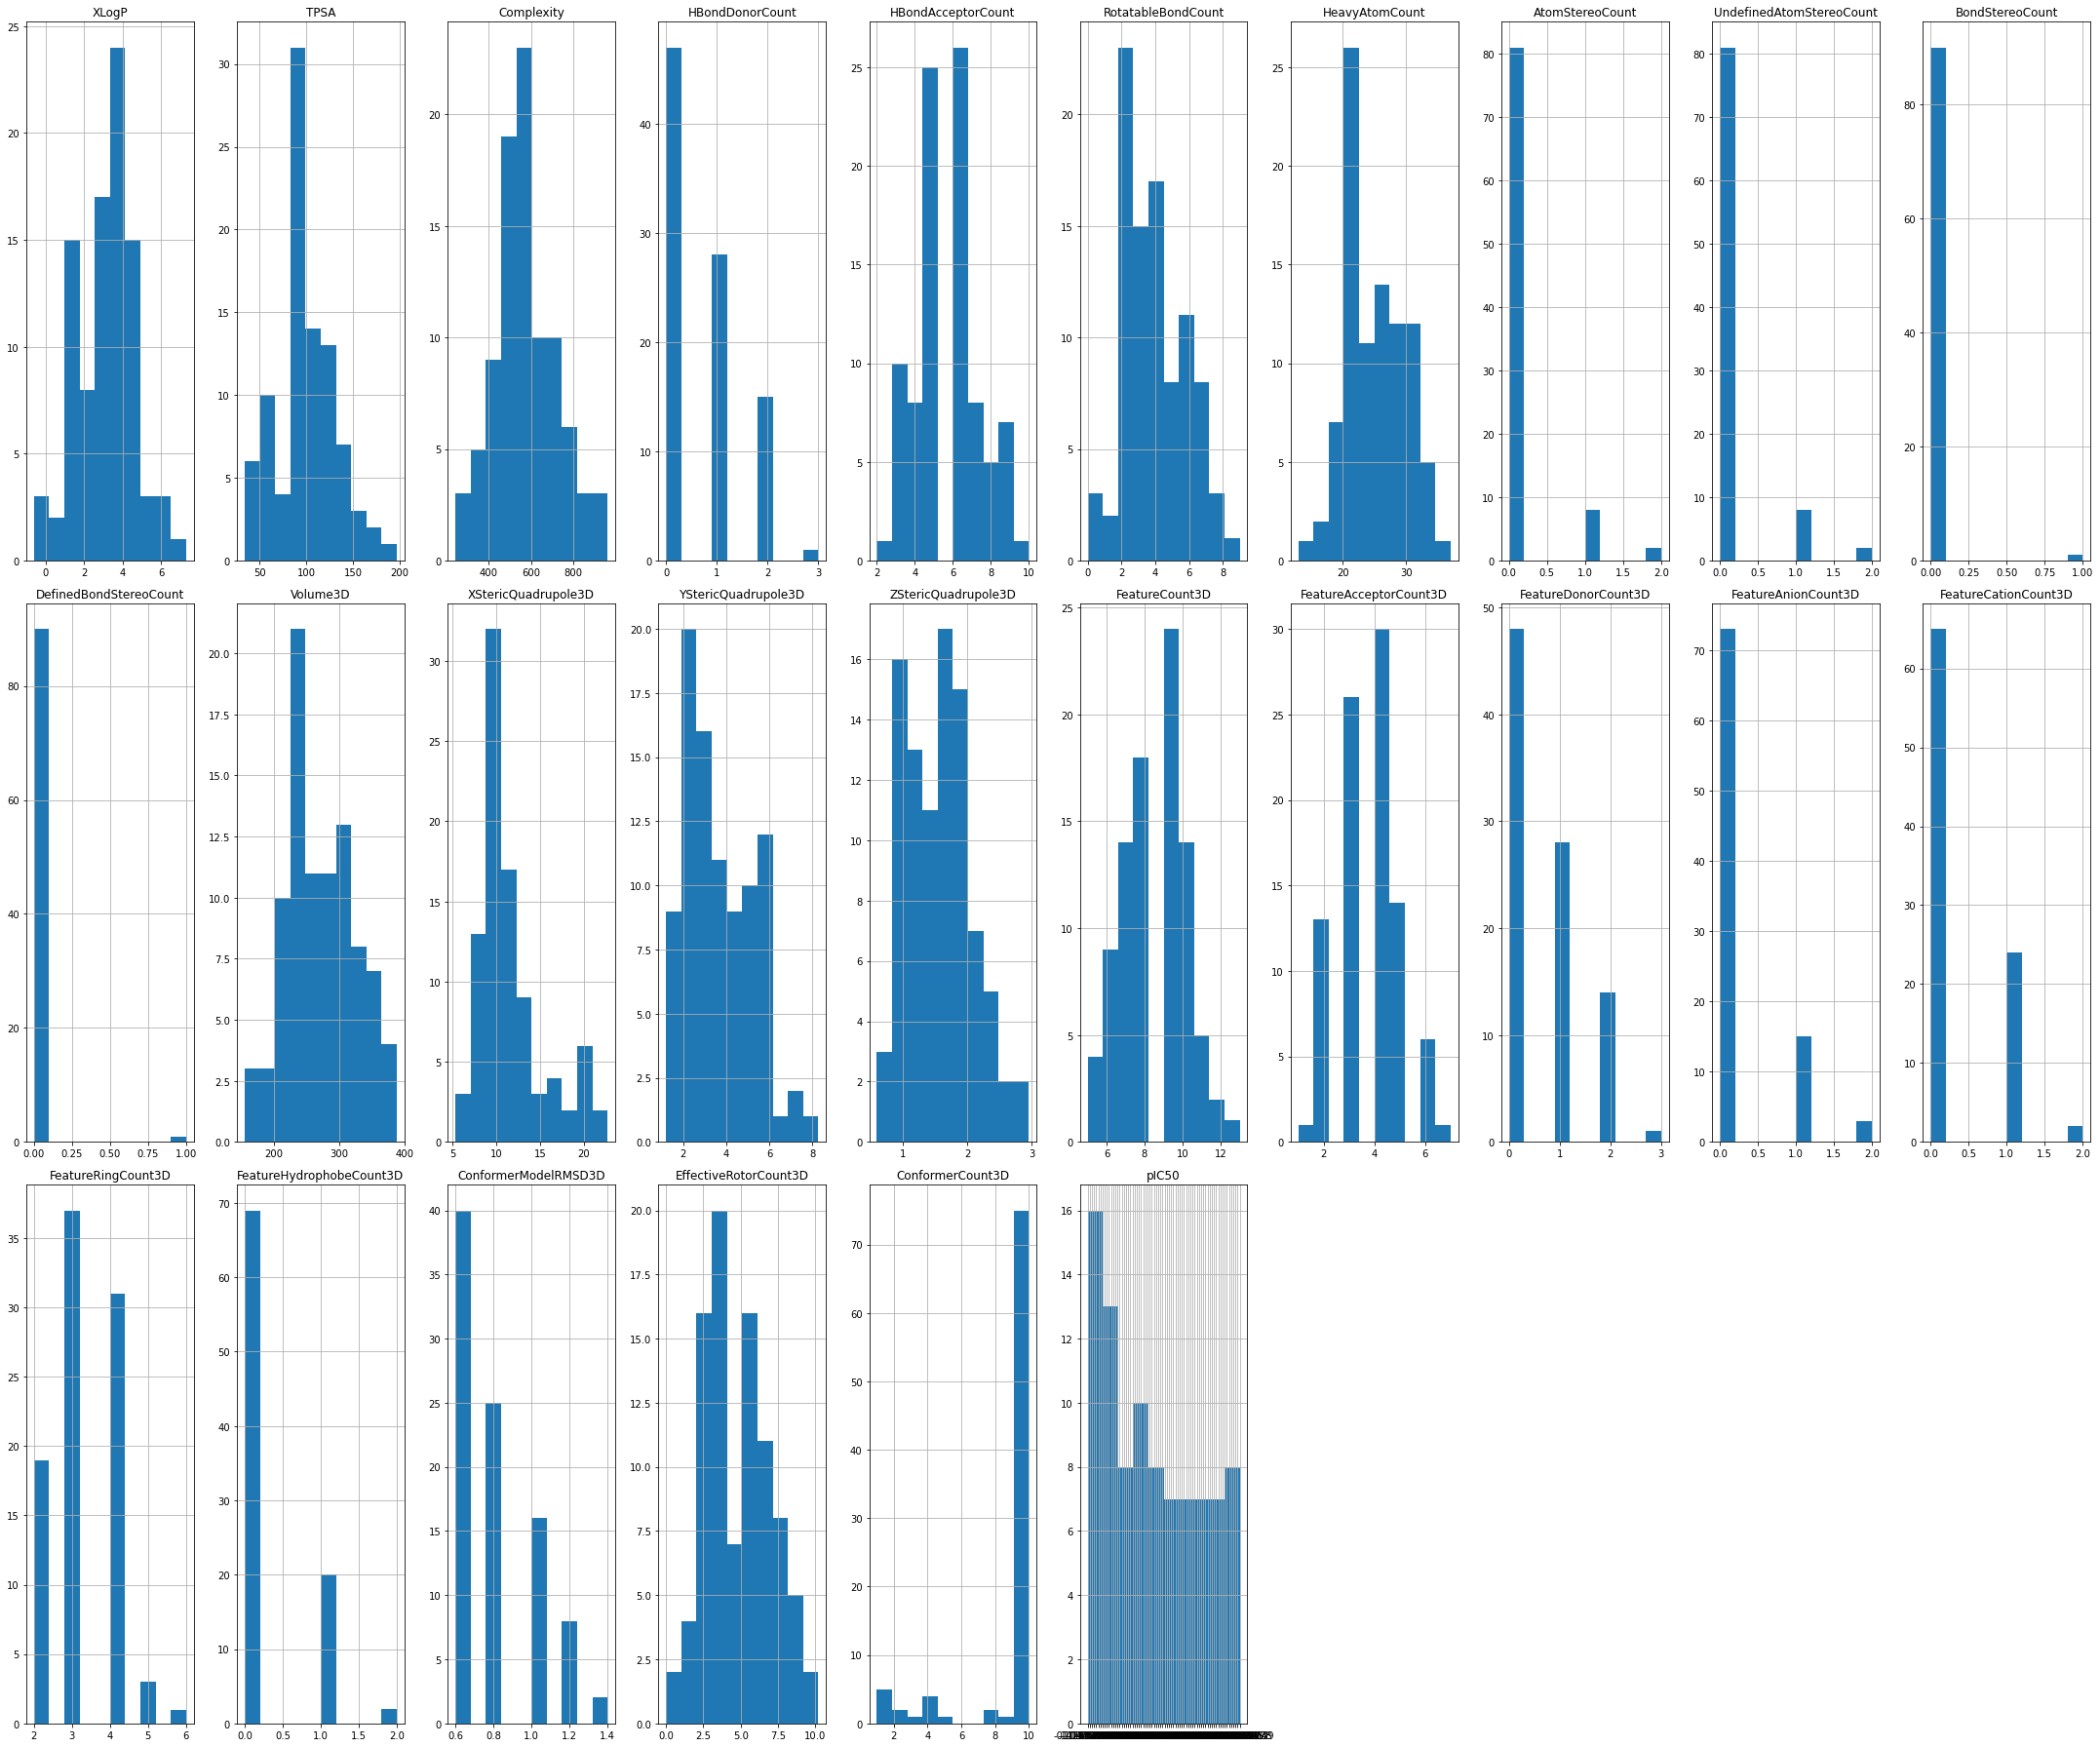

In [24]:
draw_histograms(df2, df2.columns, 3, 10)

***Are there many outliers in the data?***

In [49]:
#function to draw boxplots to check for outliers in features

def draw_boxplots(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(30, 25))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df.boxplot(var_name, ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  
    plt.show()
    


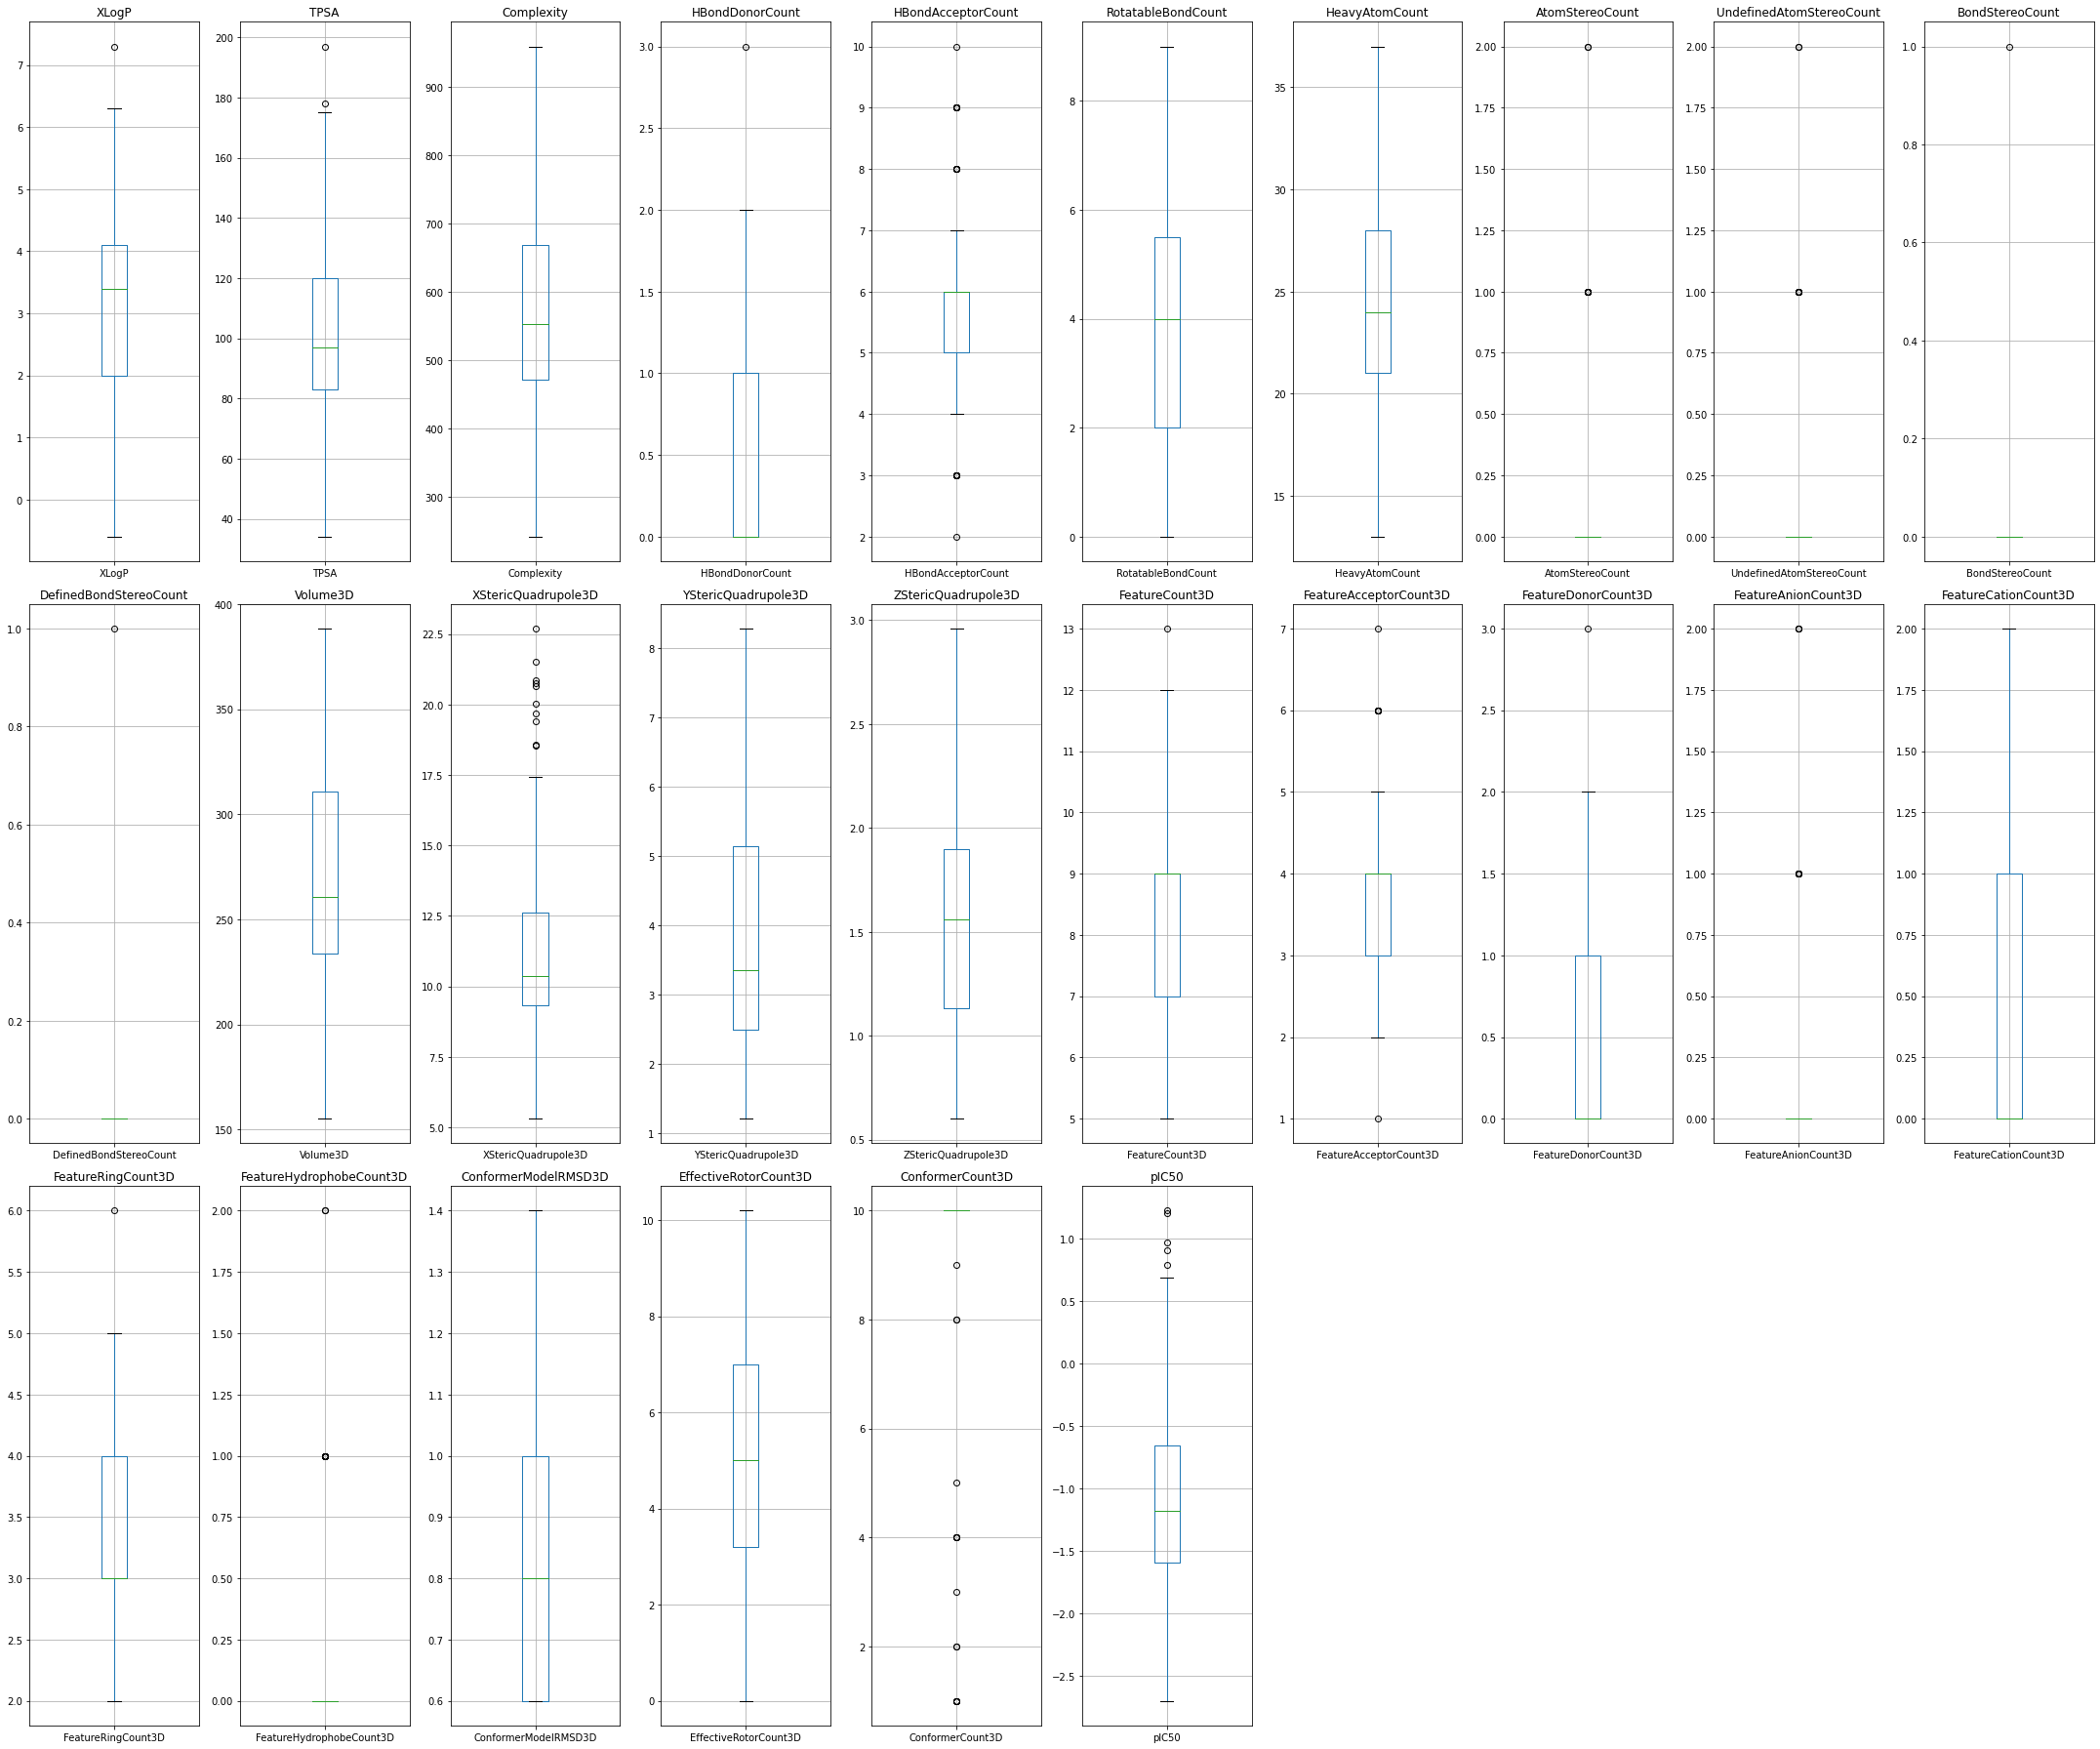

In [50]:
draw_boxplots(df2, df2.columns, 3, 10)

In [25]:
cmpd_A = pcp.Compound.from_cid(2744814)
print(cmpd_A.molecular_formula)
print(cmpd_A.iupac_name)

C21H14Cl2N4OS2
N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thiazol-4-yl)pyrimidin-2-yl]sulfanylacetamide


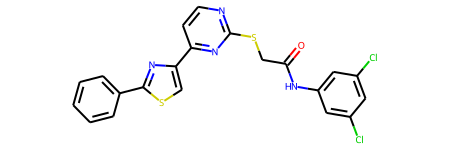

In [26]:


Chem.MolFromSmiles(df.SMILES[0])

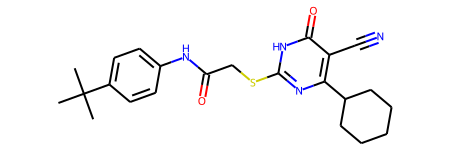

In [51]:
Chem.MolFromSmiles(df.SMILES[24])

## Modeling with statsmodels

In [27]:
df2.columns

Index(['XLogP', 'TPSA', 'Complexity', 'HBondDonorCount', 'HBondAcceptorCount',
       'RotatableBondCount', 'HeavyAtomCount', 'AtomStereoCount',
       'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount',
       'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D',
       'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D',
       'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D',
       'FeatureRingCount3D', 'FeatureHydrophobeCount3D',
       'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'ConformerCount3D',
       'pIC50'],
      dtype='object')

In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 2744814 to 44398436
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   XLogP                     91 non-null     float64
 1   TPSA                      91 non-null     float64
 2   Complexity                91 non-null     float64
 3   HBondDonorCount           91 non-null     float64
 4   HBondAcceptorCount        91 non-null     float64
 5   RotatableBondCount        91 non-null     float64
 6   HeavyAtomCount            91 non-null     float64
 7   AtomStereoCount           91 non-null     float64
 8   UndefinedAtomStereoCount  91 non-null     float64
 9   BondStereoCount           91 non-null     float64
 10  DefinedBondStereoCount    91 non-null     float64
 11  Volume3D                  91 non-null     float64
 12  XStericQuadrupole3D       91 non-null     float64
 13  YStericQuadrupole3D       91 non-null     float64
 14  

In [29]:
#convert pIC50 to numeric

df2['pIC50'] = pd.to_numeric(df2['pIC50'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 2744814 to 44398436
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   XLogP                     91 non-null     float64
 1   TPSA                      91 non-null     float64
 2   Complexity                91 non-null     float64
 3   HBondDonorCount           91 non-null     float64
 4   HBondAcceptorCount        91 non-null     float64
 5   RotatableBondCount        91 non-null     float64
 6   HeavyAtomCount            91 non-null     float64
 7   AtomStereoCount           91 non-null     float64
 8   UndefinedAtomStereoCount  91 non-null     float64
 9   BondStereoCount           91 non-null     float64
 10  DefinedBondStereoCount    91 non-null     float64
 11  Volume3D                  91 non-null     float64
 12  XStericQuadrupole3D       91 non-null     float64
 13  YStericQuadrupole3D       91 non-null     float64
 14  

In [30]:
#basic model

logp_model = ols(formula='pIC50 ~ XLogP', data=df2).fit()
logp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1217
Date:                Wed, 09 Mar 2022   Prob (F-statistic):              0.728
Time:                        10:25:46   Log-Likelihood:                -119.10
No. Observations:                  91   AIC:                             242.2
Df Residuals:                      89   BIC:                             247.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1214      0.216     -5.181      0.000      -1.551      -0.691
XLogP          0.0213      0.061      0.349      0.728      -0.100       0.143
==============================================================================
Omnibus:                        4.429   Durbin-Watson:                   0.567
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                4.089
Skew:                           0.519   Prob(JB):                        0.129
Kurtosis:                       3.048   Cond. No.                         8.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

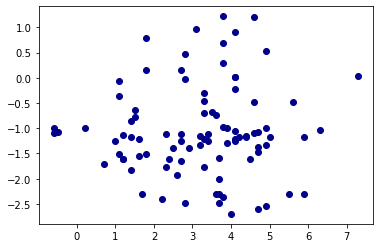

In [52]:
plt.scatter(df2['XLogP'], df2['pIC50'], c='darkblue')

In [31]:
#constructing a model using all features
formula_2 = ('pIC50 ~ XLogP +TPSA + Complexity + HBondDonorCount + HBondAcceptorCount + RotatableBondCount + HeavyAtomCount + AtomStereoCount + UndefinedAtomStereoCount + BondStereoCount + DefinedBondStereoCount + Volume3D + XStericQuadrupole3D + YStericQuadrupole3D + ZStericQuadrupole3D + FeatureCount3D + FeatureAcceptorCount3D + FeatureDonorCount3D + FeatureAnionCount3D + FeatureCationCount3D + FeatureRingCount3D + FeatureHydrophobeCount3D + ConformerModelRMSD3D + EffectiveRotorCount3D + ConformerCount3D')

all_model = ols(formula=formula_2, data=df2).fit()
all_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     4.460
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           1.03e-06
Time:                        10:25:46   Log-Likelihood:                -78.522
No. Observations:                  91   AIC:                             203.0
Df Residuals:                      68   BIC:                             260.8
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9451      0.884     -3.333      0.001      -4.708      -1.182
XLogP                        0.1827      0.119      1.537      0.129      -0.055       0.420
TPSA                        -0.0121      0.008     -1.485      0.142      -0.028       0.004
Complexity                  -0.0029      0.002     -1.364      0.177      -0.007       0.001
HBondDonorCount             -0.7961      0.637     -1.250      0.216      -2.067       0.475
HBondAcceptorCount           0.1796      0.140      1.282      0.204      -0.100       0.459
RotatableBondCount           0.3035      0.194      1.563      0.123      -0.084       0.691
HeavyAtomCount              -0.0285      0.220     -0.130      0.897      -0.468       0.411
AtomStereoCount             -0.0550      0.098     -0.560      0.577      -0.251       0.141
UndefinedAtomStereoCount    -0.0550      0.098     -0.560      0.577      -0.251       0.141
BondStereoCount             -0.5271      0.357     -1.477      0.144      -1.239       0.185
DefinedBondStereoCount      -0.5271      0.357     -1.477      0.144      -1.239       0.185
Volume3D                     0.0093      0.016      0.570      0.570      -0.023       0.042
XStericQuadrupole3D          0.0295      0.036      0.819      0.416      -0.042       0.101
YStericQuadrupole3D          0.0675      0.151      0.446      0.657      -0.234       0.369
ZStericQuadrupole3D          0.2973      0.249      1.194      0.237      -0.200       0.794
FeatureCount3D               0.1578      0.181      0.873      0.386      -0.203       0.518
FeatureAcceptorCount3D       0.1474      0.188      0.785      0.435      -0.227       0.522
FeatureDonorCount3D          0.7871      0.576      1.366      0.176      -0.363       1.937
FeatureAnionCount3D          0.4043      0.297      1.363      0.177      -0.188       0.996
FeatureCationCount3D        -0.6166      0.269     -2.290      0.025      -1.154      -0.079
FeatureRingCount3D          -0.1507      0.225     -0.671      0.504      -0.599       0.297
FeatureHydrophobeCount3D    -0.4137      0.239     -1.730      0.088      -0.891       0.064
ConformerModelRMSD3D        -0.6595      0.866     -0.761      0.449      -2.388       1.069
EffectiveRotorCount3D       -0.5729      0.174     -3.296      0.002      -0.920      -0.226
ConformerCount3D             0.1496      0.045      3.359      0.001       0.061       0.238
==============================================================================
Omnibus:                        0.281   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.366
Skew:                          -0.126   Prob(JB):                        0.833
Kurtosis:                       2.819   Cond. No.                     

### Insight:
all_model has strong multicolllinearity issues. This is not surprising, considering that the correlation heatmap shows this numerically. Features that are collinear (r2 > 0.7) with 3 or more other features will be dropped to see if the model is improved.

In [32]:
Multicorr = ['YStericQuadrupole3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'Volume3D']

In [33]:
formula_3 = ('pIC50 ~ XLogP + TPSA + Complexity + HBondDonorCount + HBondAcceptorCount + RotatableBondCount + HeavyAtomCount + AtomStereoCount + UndefinedAtomStereoCount + BondStereoCount + DefinedBondStereoCount + XStericQuadrupole3D + ZStericQuadrupole3D + FeatureCount3D + FeatureAcceptorCount3D + FeatureDonorCount3D + FeatureAnionCount3D + FeatureCationCount3D + FeatureRingCount3D + FeatureHydrophobeCount3D + ConformerCount3D')

model2 = ols(formula=formula_3, data=df2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     4.197
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           6.33e-06
Time:                        10:25:46   Log-Likelihood:                -86.515
No. Observations:                  91   AIC:                             211.0
Df Residuals:                      72   BIC:                             258.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.8691      0.807     -2.315      0.023      -3.478      -0.260
XLogP                        0.2953      0.120      2.460      0.016       0.056       0.535
TPSA                        -0.0054      0.006     -0.869      0.388      -0.018       0.007
Complexity                  -0.0009      0.002     -0.455      0.651      -0.005       0.003
HBondDonorCount              0.1317      0.580      0.227      0.821      -1.024       1.287
HBondAcceptorCount           0.0508      0.126      0.403      0.688      -0.201       0.302
RotatableBondCount          -0.1266      0.146     -0.868      0.388      -0.417       0.164
HeavyAtomCount              -0.0711      0.121     -0.590      0.557      -0.311       0.169
AtomStereoCount             -0.0739      0.101     -0.729      0.469      -0.276       0.128
UndefinedAtomStereoCount    -0.0739      0.101     -0.729      0.469      -0.276       0.128
BondStereoCount             -0.3807      0.372     -1.023      0.310      -1.123       0.361
DefinedBondStereoCount      -0.3807      0.372     -1.023      0.310      -1.123       0.361
XStericQuadrupole3D          0.0372      0.027      1.397      0.167      -0.016       0.090
ZStericQuadrupole3D          0.1737      0.223      0.779      0.439      -0.271       0.618
FeatureCount3D              -0.0485      0.153     -0.316      0.753      -0.354       0.257
FeatureAcceptorCount3D       0.3329      0.181      1.838      0.070      -0.028       0.694
FeatureDonorCount3D         -0.1626      0.492     -0.331      0.742      -1.143       0.818
FeatureAnionCount3D          0.1832      0.257      0.713      0.478      -0.329       0.695
FeatureCationCount3D        -0.2173      0.240     -0.907      0.367      -0.695       0.260
FeatureRingCount3D           0.1437      0.214      0.672      0.504      -0.283       0.570
FeatureHydrophobeCount3D    -0.3284      0.199     -1.653      0.103      -0.725       0.068
ConformerCount3D             0.1230      0.044      2.781      0.007       0.035       0.211
==============================================================================
Omnibus:                        0.174   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.917   Jarque-Bera (JB):                0.025
Skew:                          -0.038   Prob(JB):                        0.988
Kurtosis:                       3.025   Cond. No.                     1.89e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.17e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [34]:
#dropping TSPA and complexity, along with other features that are collinear(featuredonorcount3D)

formula_4 = ('pIC50 ~ XLogP + HBondDonorCount + HBondAcceptorCount + RotatableBondCount + HeavyAtomCount + AtomStereoCount + UndefinedAtomStereoCount + BondStereoCount + DefinedBondStereoCount + XStericQuadrupole3D + ZStericQuadrupole3D + FeatureCount3D + FeatureAcceptorCount3D + FeatureAnionCount3D + FeatureCationCount3D + FeatureRingCount3D + FeatureHydrophobeCount3D + ConformerCount3D')

model3 = ols(formula=formula_4, data=df2).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     4.653
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           2.42e-06
Time:                        10:25:47   Log-Likelihood:                -87.484
No. Observations:                  91   AIC:                             209.0
Df Residuals:                      74   BIC:                             251.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.7587      0.655     -2.686      0.009      -3.063      -0.454
XLogP                        0.2990      0.104      2.885      0.005       0.093       0.506
HBondDonorCount              0.2153      0.558      0.386      0.701      -0.897       1.328
HBondAcceptorCount          -0.0036      0.094     -0.038      0.970      -0.191       0.184
RotatableBondCount          -0.1342      0.105     -1.274      0.207      -0.344       0.076
HeavyAtomCount              -0.0865      0.057     -1.507      0.136      -0.201       0.028
AtomStereoCount             -0.0768      0.101     -0.760      0.450      -0.278       0.124
UndefinedAtomStereoCount    -0.0768      0.101     -0.760      0.450      -0.278       0.124
BondStereoCount             -0.4129      0.370     -1.116      0.268      -1.150       0.324
DefinedBondStereoCount      -0.4129      0.370     -1.116      0.268      -1.150       0.324
XStericQuadrupole3D          0.0410      0.024      1.719      0.090      -0.007       0.089
ZStericQuadrupole3D          0.1297      0.218      0.595      0.553      -0.304       0.564
FeatureCount3D              -0.3993      0.564     -0.708      0.481      -1.523       0.724
FeatureAcceptorCount3D       0.6318      0.570      1.108      0.271      -0.504       1.768
FeatureAnionCount3D          0.4602      0.581      0.792      0.431      -0.698       1.618
FeatureCationCount3D         0.1815      0.598      0.303      0.762      -1.010       1.373
FeatureRingCount3D           0.4401      0.590      0.746      0.458      -0.736       1.616
FeatureHydrophobeCount3D    -0.0296      0.566     -0.052      0.958      -1.157       1.098
ConformerCount3D             0.1237      0.044      2.807      0.006       0.036       0.212
==============================================================================
Omnibus:                        0.050   Durbin-Watson:                   1.473
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.094
Skew:                          -0.051   Prob(JB):                        0.954
Kurtosis:                       2.881   Cond. No.                     2.25e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.84e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [43]:
#only including features from model3 in the formula where p<0.1

formula_5 = 'pIC50 ~ XLogP + ConformerCount3D + XStericQuadrupole3D'

model4 = ols(formula=formula_5, data=df2).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.737
Date:                Wed, 09 Mar 2022   Prob (F-statistic):              0.165
Time:                        12:21:58   Log-Likelihood:                -116.51
No. Observations:                  91   AIC:                             241.0
Df Residuals:                      87   BIC:                             251.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.7300      0.419     -4.133      0.000      -2.562      -0.898
XLogP                  -0.0131      0.062     -0.211      0.834      -0.136       0.110
ConformerCount3D        0.0059      0.036      0.163      0.871      -0.066       0.078
XStericQuadrupole3D     0.0571      0.027      2.147      0.035       0.004       0.110
==============================================================================
Omnibus:                        2.054   Durbin-Watson:                   0.638
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                2.012
Skew:                           0.351   Prob(JB):                        0.366
Kurtosis:                       2.806   Cond. No.                         69.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Insight:
model 4 is the first model that isn't subjected to multicollinearity. Will add features to optimize the model

In [44]:
#adding features from model3 where p<0.25

formula_6 = 'pIC50 ~ XLogP + ConformerCount3D + XStericQuadrupole3D + HeavyAtomCount + RotatableBondCount'

model5 = ols(formula=formula_6, data=df2).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pIC50   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     7.388
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           8.56e-06
Time:                        12:31:03   Log-Likelihood:                -102.74
No. Observations:                  91   AIC:                             217.5
Df Residuals:                      85   BIC:                             232.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1893      0.588     -2.022      0.046      -2.359      -0.020
XLogP                   0.1253      0.060      2.102      0.038       0.007       0.244
ConformerCount3D        0.1050      0.037      2.817      0.006       0.031       0.179
XStericQuadrupole3D     0.0560      0.023      2.419      0.018       0.010       0.102
HeavyAtomCount         -0.0426      0.025     -1.716      0.090      -0.092       0.007
RotatableBondCount     -0.2000      0.065     -3.063      0.003      -0.330      -0.070
==============================================================================
Omnibus:                        0.627   Durbin-Watson:                   0.990
Prob(Omnibus):                  0.731   Jarque-Bera (JB):                0.759
Skew:                           0.123   Prob(JB):                        0.684
Kurtosis:                       2.626   Cond. No.                         217.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


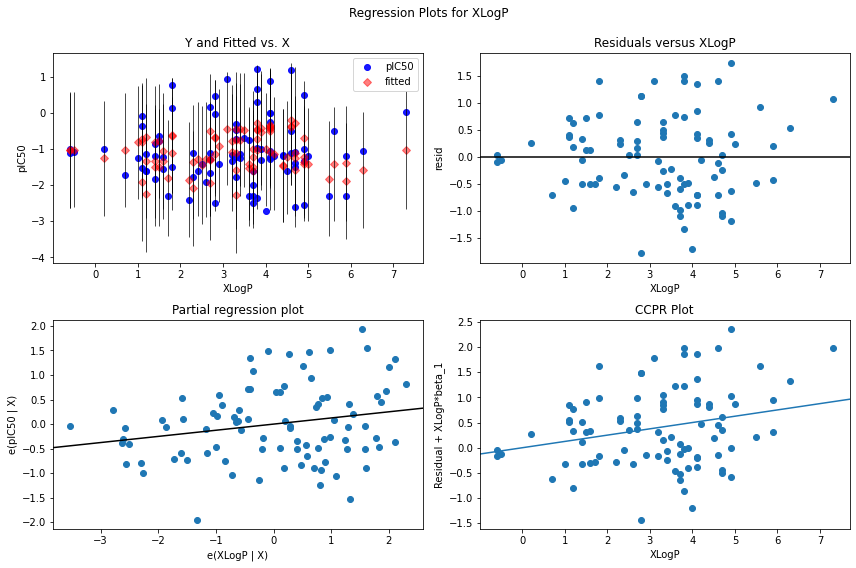

In [46]:
#does this model follow assumptions of linear regression?

sm.graphics.plot_regress_exog(model5, 'XLogP', fig=plt.figure(figsize=(12, 8)));

## Modeling with sklearn LinearRegression

In [35]:
#creating X and y, performing tts for sklearn linear regression 

todrop =['pIC50', 'YStericQuadrupole3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'Volume3D', 'TPSA',
        'Complexity', 'FeatureDonorCount3D']

y = df2[['pIC50']]
X = df2.drop(todrop, axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [37]:
#creation of baseline dummy regressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dy_pred = dummy.predict(X_train)
dy_pred_test = dummy.predict(X_test)

In [38]:
dummy.score(X_train, y_train)

0.0

In [39]:
#linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_trainpred = lr.predict(X_train)
y_testpred = lr.predict(X_test)

lr.score(X_train, y_train)

0.6877406078319852

In [40]:
r2_score(y_train, y_trainpred)

0.6877406078319852

In [41]:
r2_score(y_test, y_testpred)

-1.3164227435333298

In [42]:
RMSE_train = mean_squared_error(y_train, y_trainpred, squared=False)
RMSE_test = mean_squared_error(y_test, y_testpred, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  1.0221344451968883
RMSE for training set is:  0.5593464093630773
